In [1]:
import tensorflow as tf
import numpy as np
import input_data
import matplotlib.pyplot as plt
import os

In [2]:
from scipy.misc import imsave as ims
from matplotlib import pyplot as plt
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx / size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

In [3]:
class VAE():
    def __init__(self):
        tf.reset_default_graph()         
        self.mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
        self.n_samples = self.mnist.train.num_examples

        self.n_hidden = 500
        self.n_z = 20
        self.batchsize = 100

        self.images = tf.placeholder(tf.float32, [None, 784])
        image_matrix = tf.reshape(self.images,[-1, 28, 28, 1])
        z_mean, z_stddev = self.encoder(image_matrix)
        
        samples = tf.random_normal([self.batchsize,self.n_z],0,1,dtype=tf.float32)
        guessed_z = z_mean + (z_stddev * samples)

        self.generated_images = self.decoder(guessed_z)
        generated_flat = tf.reshape(self.generated_images, [self.batchsize, 28*28])

        self.generation_loss = -tf.reduce_sum(self.images * tf.log(1e-8 + generated_flat) + (1-self.images) * tf.log(1e-8 + 1 - generated_flat),1)

        self.latent_loss = 0.5 * tf.reduce_sum(tf.square(z_mean) + tf.square(z_stddev) - tf.log(tf.square(z_stddev)) - 1,1)
        self.cost = tf.reduce_mean(self.generation_loss + self.latent_loss)
        self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)


    # encoder
    def encoder(self, input_images):
        with tf.variable_scope("recognition"):
            wh1 = tf.get_variable("wh1",[5,5,1, 16])
            bh1 = tf.get_variable("bh1",[16])
            conv1 = tf.nn.conv2d(input_images, wh1, strides=[1,2,2,1], padding="SAME",name="conv1") + bh1
            
            h1 = tf.nn.relu(conv1)
            h1_flat = tf.reshape(h1,[self.batchsize, 14*14*16])
            
            wm = tf.get_variable("wm", [14*14*16, self.n_z], tf.float32)
            bm = tf.get_variable("bm", [self.n_z])
            w_mean = tf.matmul(h1_flat, wm)+bm
            
            ws = tf.get_variable("ws", [14*14*16, self.n_z], tf.float32)
            bs = tf.get_variable("bs", [self.n_z])
            w_stddev = tf.matmul(h1_flat, ws)+bs

        return w_mean, w_stddev

    # decoder
    def decoder(self, z):
        with tf.variable_scope("generation"):
            wz = tf.get_variable("wz", [self.n_z, 14*14*16], tf.float32)
            bz = tf.get_variable("bz", [14*14*16])
            z_develop = tf.matmul(z, wz) + bz 
            z_matrix = tf.nn.relu(tf.reshape(z_develop, [self.batchsize, 14,14,16]),name="z_matrix")
            
            wh2 = tf.get_variable("wh2",[5,5, 1, 16])
            bh2 = tf.get_variable("bh2",[1])
            conv2 = tf.nn.conv2d_transpose(z_matrix, wh2, output_shape=[self.batchsize, 28, 28, 1], strides=[1,2,2,1],name="conv2")+bh2
            h2 = tf.nn.sigmoid(conv2)

        return h2

    def train(self):
        test = self.mnist.train.next_batch(self.batchsize)[0]
        reshaped_test = test.reshape(self.batchsize,28,28)
        ims("results/base.jpg",merge(reshaped_test[:64],[8,8]))
        plt.figure()
        plt.imshow(merge(reshaped_test[:64],[8,8]))
        plt.show()
        # train
        
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            for epoch in range(10):
                for idx in range(int(self.n_samples / self.batchsize)):
                    batch = self.mnist.train.next_batch(self.batchsize)[0]
                    _, gen_loss, lat_loss = sess.run((self.optimizer, self.generation_loss, self.latent_loss), feed_dict={self.images: batch})
                    
                    if idx % (self.n_samples - 3) == 0:
                        print "epoch %d: genloss %f latloss %f" % (epoch, np.mean(gen_loss), np.mean(lat_loss))
                        
                        generated_test = sess.run(self.generated_images, feed_dict={self.images: test})
                        generated_test = generated_test.reshape(self.batchsize,28,28)
                        ims("results/"+str(epoch)+".jpg",merge(generated_test[:64],[8,8]))
            
                        plt.figure()
                        plt.title("epoch: %d"%epoch)
                        plt.imshow(merge(generated_test[:64],[8,8]))
                        plt.show()
                    
    



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


/home/kiruthika/miniconda2/envs/magentatest/lib/python2.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


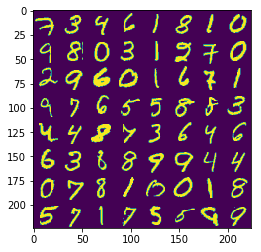

Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch 0: genloss 506.508636 latloss 28.768353


/home/kiruthika/miniconda2/envs/magentatest/lib/python2.7/site-packages/ipykernel_launcher.py:84: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


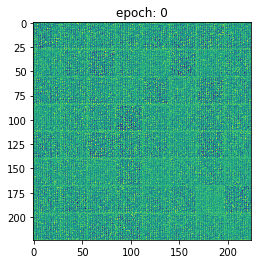

epoch 1: genloss 120.068909 latloss 24.039112


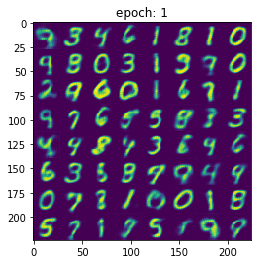

epoch 2: genloss 99.610695 latloss 25.467564


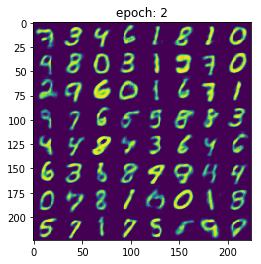

epoch 3: genloss 88.304420 latloss 25.142328


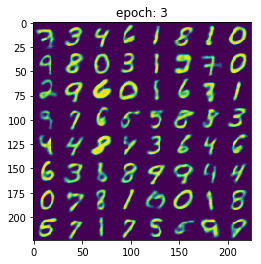

epoch 4: genloss 88.619377 latloss 26.847340


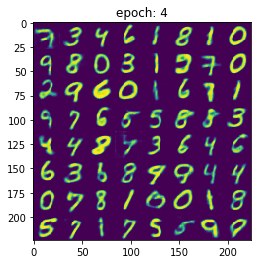

epoch 5: genloss 86.557724 latloss 25.646214


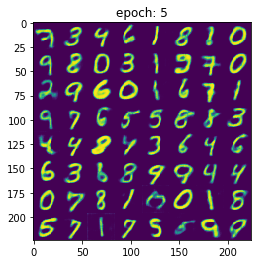

epoch 6: genloss 83.757263 latloss 25.805431


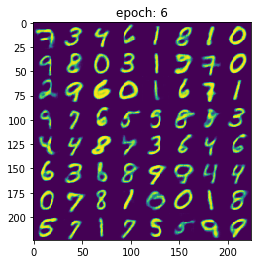

epoch 7: genloss 80.726418 latloss 27.449635


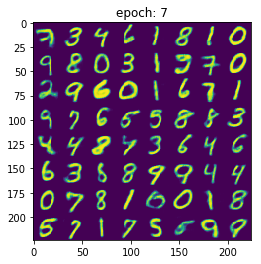

epoch 8: genloss 81.578537 latloss 25.939770


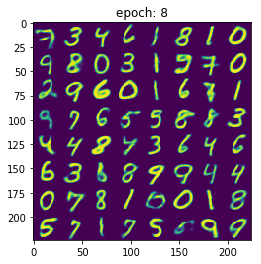

epoch 9: genloss 81.357292 latloss 25.234535


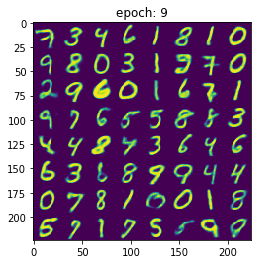

In [5]:
model = VAE()
model.train()